In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
import seaborn as sns
from functions import create_base, add_basket_info, add_coupon_info
from functions import get_baskets, get_coupons, get_prediction_index, get_3_files
from functions import split_4_way

In [2]:
baskets, coupons, prediction_index = get_3_files()
baskets = baskets[baskets['customer'] < 2000]

In [28]:
base = create_base(customers=range(0,2000))
base['basket'] = base['week'].astype(str) + '_' +base['customer'].astype(str)
base = add_basket_info(base, baskets)
base = add_coupon_info(base, baskets, coupons)
base

,week,customer,product,basket,price,category,isBought,dGiven,isGiven,isUsed
0,0,0,0,0_0,0,NaN,False,0,False,False
1,0,0,1,0_0,0,NaN,False,0,False,False
2,0,0,2,0_0,0,NaN,False,0,False,False
3,0,0,3,0_0,0,NaN,False,0,False,False
4,0,0,4,0_0,0,NaN,False,0,False,False
...,...,...,...,...,...,...,...,...,...,...
44999995,89,1999,245,89_1999,549,24.0,True,0,False,False
44999996,89,1999,246,89_1999,0,NaN,False,30,True,False
44999997,89,1999,247,89_1999,0,NaN,False,0,False,False
44999998,89,1999,248,89_1999,0,NaN,False,0,False,False


# Creating categories

In [ ]:
n_baskets = base['basket'].nunique()

matrix = np.matrix([np.array(base.iloc[x*250:x*250+250,5]) for x in range(n_baskets)]).astype(int)
occurency_matrix = matrix.T.dot(matrix)
occurency_matrix[occurency_matrix > 1] = 1

sns.set(rc={'figure.figsize':(6,5)})
sns.heatmap(occurency_matrix, annot=False)

<AxesSubplot:>

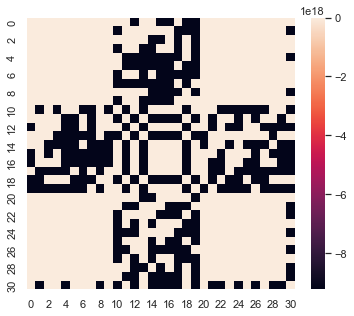

In [ ]:
sns.heatmap(occurency_matrix[:31,:31], annot=False)

In [14]:
base['category'] = (base['product'] / 10).astype(int)

# Adding probabilities (product & category)

In [15]:
prod_probs_df = (
    baskets.groupby(['customer','product'])['week'].count() / 90) \
    .reset_index() \
    .rename(columns={'week':'probability'})
    
baskets['category'] = (baskets['product'].astype(int) / 10).astype(int)

cat_probs_df = (
    baskets.groupby(['customer','category'])['week'].count() / 90) \
    .reset_index() \
    .rename(columns={'week':'probability'})
    
base = pd.merge(base, prod_probs_df, on=['customer','product'] ,how='left')
base = pd.merge(base, cat_probs_df, on=['customer','category'] ,how='left')
base.rename(columns={'probability_x':'p_prob', 'probability_y':'p_cat'},inplace=True)

# Modelling

In [16]:
def split(df, train=True, week=89):
    return df[df['week']!=week] if train else df[df['week']==week]

y_train = split(base, train=True)['isBought'].values
y_test =  split(base, train=False)['isBought'].values

In [24]:
base['p_cat'] = base['p_cat'].fillna(0)

base2 = base[['week','product','dGiven','isBought','isGiven','p_prob','p_cat']]
x_train, y_train, x_test, y_test = split_4_way(base2, target_col='isBought', unkwown_week=89)

model = linear_model.LogisticRegression()
model.fit(X=x_train,y=y_train)
predictions = model.predict_proba(x_test)
loss = metrics.log_loss(y_test, predictions)
print(f'Loss: {round(loss,3)}')

model = ensemble.GradientBoostingClassifier() #0.071
model.fit(X=x_train,y=y_train)
predictions = model.predict_proba(x_test)
loss = metrics.log_loss(y_test, predictions)
print(f'Loss: {round(loss,3)}')

Loss: 0.088


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Loss: 0.45
Loss: 0.071


In [25]:
base

,week,customer,product,basket,price,category,isBought,dGiven,isGiven,isUsed,p_prob,p_cat
0,0,1900,0,0_1900,0,0,False,0,False,False,0.000000,0.200000
1,0,1900,1,0_1900,0,0,False,0,False,False,0.066667,0.200000
2,0,1900,2,0_1900,0,0,False,0,False,False,0.044444,0.200000
3,0,1900,3,0_1900,0,0,False,0,False,False,0.000000,0.200000
4,0,1900,4,0_1900,0,0,False,0,False,False,0.000000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
2249995,89,1999,245,89_1999,549,24,True,0,False,False,0.133333,0.622222
2249996,89,1999,246,89_1999,0,24,False,30,True,False,0.000000,0.622222
2249997,89,1999,247,89_1999,0,24,False,0,False,False,0.000000,0.622222
2249998,89,1999,248,89_1999,0,24,False,0,False,False,0.000000,0.622222
